## Optimizer Test

In [1]:
import mitsuba as mi
import numpy as np

mi.set_variant('cuda_ad_rgb')

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [2]:
scene = mi.load_file('scenes/scene.xml')

In [3]:
image_ref = mi.render(scene, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [4]:
params = mi.traverse(scene)

key = 'Cube.interior_medium.sigma_t.value.value'

# Save the original value
param_ref = mi.Color3f(params[key])

# Set another color value and update the scene
params[key] = mi.Color3f(0.8, 0.1, 0.9)
params.update();

In [5]:
image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [6]:
opt = mi.ad.Adam(lr=0.05)
opt[key] = params[key]
params.update(opt);

In [7]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In [8]:
iteration_count = 50

In [9]:
errors = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

In [ ]:
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

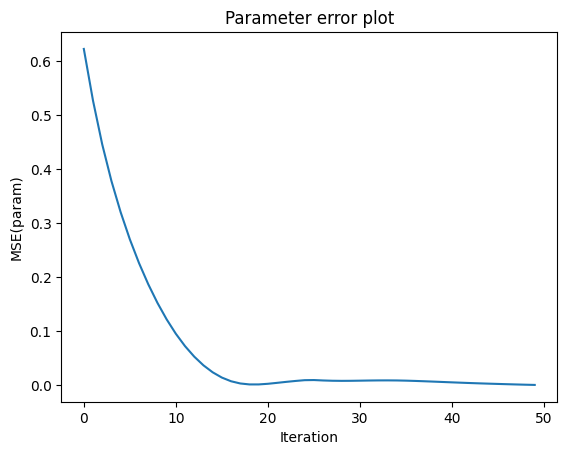

In [17]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()